In [2]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.io import loadmat
import random
from numpy import linalg as LA
import time
from IPython import display

# import functions from other python files
from fun1d import *

In [3]:
def diff_2mom(y0, sigmax, sx, psi_hat, psi):
    wy = wave_trans_in_freq_1d(y0, psi_hat)
    sy = np.sum(np.abs(wy),axis = 0)
#     sigmay = np.matmul(np.transpose(wy), np.conjugate(wy)) # covariance
    sigmay = np.sum(np.abs(wy)**2, axis = 0) # (diagonal covariance) 2nd moments
    diff = np.sum((sx - sy)**2) + np.sum((sigmay - sigmax)**2)
return diff

def jac_2mom(y0, sigmax, sx, psi_hat, psi):
    # jacobian function for difference
    epsilon = 1e-6
    n = y0.shape[0]
    nw = psi_hat.shape[1]
    
    if nw == len(sx):
        z = False
        sx_z = np.append([0], sx)
    else:
        z = True
        sx_z = sx
    
    wy = wave_trans_in_freq_1d(y0, psi_hat)
    temp1 = jac(y0, sx_z, psi_hat, psi, z) # first moment derivative
    temp = np.zeros((n,nw))
    
    psi_shift = np.zeros((n,n,nw), dtype = complex)
    psi_fftshift = np.fft.fftshift(psi, axes = 0)
    
    sigmay = np.sum(np.abs(wy)**2, axis = 0)
    
    for i in range(nw):
        for p in range(n):
            psi_shift[:, p, i] = np.roll(psi_fftshift[:,i], p, axis = 0)
        temp = 2 * np.matmul(np.real(wy[:,i]), np.real(psi_shift[:,:,i])) + \
                    2 * np.matmul(np.imag(wy[:,i]), np.imag(psi_shift[:,:,i]))
        temp1 = temp1 + 2 * (sigmay[i] - sigmax[i]) * temp
    return temp1


def syn_2mom(x, psi_hat, psi, jacob, max_err, max_epoch, *args):
    # collect parameters
    nx = x.shape
    nw = psi_hat.shape[1]  # number of wavelets 
    
    # scattering coefficients of original signal
    wx = wave_trans_in_freq_1d(x, psi_hat)
    sx = np.sum(np.abs(wx), axis = 0)
    sx = np.append(np.sum(x), sx)
    sigmax = np.sum(np.abs(wx)**2, axis = 0)

    # initialize new signal
    narg = len(args)
    if narg == 0:
        y0 = np.random.random((nx[0],1)) 
    else:
        y0 = args[0]
        
    y = y0
    
    err = 1
    epoch = 0
    tic = time.time()
    while (epoch < max_epoch):
        
        epoch += 1
        ind = np.random.choice(nw, nw, replace = False) # randomize index of wavelets
        print('epoch:', epoch)
        
        for i in range(nw):
            # specify jacobian
            if jacob:
                res = minimize(diff_2mom, y0, args = (sigmax[ind[0:i+1]], \
                                                      sx[ind[0:i+1]], \
                                                      psi_hat[:,ind[0:i+1]], \
                                                      psi[:,ind[0:i+1]]), \
                               jac = jac_2mom, method='BFGS')
            # not specify jacobian
            else:
                res = minimize(diff_2mom, y0, args = (sigmax[ind[0:i+1]], \
                                                      sx[ind[0:i+1]], \
                                                      psi_hat[:,ind[0:i+1]], \
                                                      psi[:,ind[0:i+1]]), \
                               method='BFGS')
            y0 = res.x
            y = np.append(y, np.reshape(y0, (y0.shape[0], 1)), axis = 1)
            
            err = res.fun
#             print('current error:', err)
        
    toc = time.time()
#     print('running time: ', toc - tic)
    return y

In [4]:
n = 1024
l = 0.01
pi = math.pi
max_err = 1e-7
max_epoch = 3
jacob = True
z = False
epsilon = 1e-4

# define filters
sigma = determine_sigma(epsilon)
Q = 2
alpha = 2
J = determine_J(n, Q, sigma, alpha)
s = np.unique(np.floor(2 ** np.linspace(0, J, int(J*Q)+1)))
xi = 2 * pi * np.random.choice(n,1) / n
g, g_hat = window_filter_family_1d(n, s, xi, sigma)
g = np.reshape(g, (g.shape[0], -1))
g_hat = np.reshape(g_hat, (g_hat.shape[0], -1))

t = np.linspace(0, n + 1, n + 1)
y = sample_poisson(t, l)[0]
dy = np.diff(y)


In [28]:
# res = syn_2mom(dy, g_hat, g, jacob, max_err, max_epoch)

In [5]:
# load results synthesized by previous optimization method(add one wavelet each optimization)
res1 = np.load('res_2mom1.npy')
g_hat1 = np.load('g_hat_2mom1.npy')

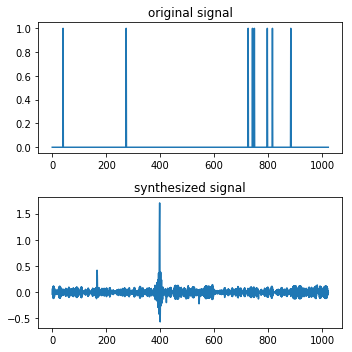

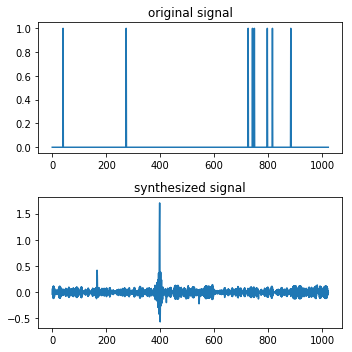

In [27]:
fig = plt.figure()
plt.figure(figsize = (5,5))
plt.subplot(2,1,1)
plt.plot(res1[:, 0]) # target signal
plt.title('original signal')
ax2 = plt.subplot(2,1,2)
for i in range(res1.shape[1] - 1):
    ax2.clear()
    ax2.plot(res1[:, i+1]) # synthesized signal from each iteration
    ax2.set_title('synthesized signal')
    print(i)
    plt.tight_layout()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.5)
    


In [22]:
# fig = plt.figure()
# plt.figure(figsize = (5,5))
# plt.subplot(2,1,1)
# plt.plot(res1[:, 0]) # target signal
# plt.title('original signal')
# ax2 = plt.subplot(2,1,2)
# plt.plot(res1[:, -1])
# plt.title('synthesized signal')

In [1]:

# for i in range(res1.shape[1]):
#     y0 = res1[:,i]
#     x = res1[:,0]
#     wx = wave_trans_in_freq_1d(x, g_hat1)
#     wy = wave_trans_in_freq_1d(y0, g_hat1)
#     sx = np.sum(np.abs(wx), axis = 0)
#     sy = np.sum(np.abs(wy), axis = 0)

#     # sx = np.sum(np.abs(wave_trans_in_freq_1d(res1[:,0], g_hat1)), axis = 0)
#     print('first moment difference:', np.sum((sx - sy)**2))
    

In [2]:
# for i in range(res1.shape[1]):
#     y0 = res1[:,i]
#     x = res1[:,0]
#     wx = wave_trans_in_freq_1d(x, g_hat1)
#     wy = wave_trans_in_freq_1d(y0, g_hat1)
#     sigmax = np.sum(np.abs(wx)**2, axis = 0)
#     sigmay = np.sum(np.abs(wy)**2, axis = 0)
#     print('2nd moment difference:', np.sum((sigmax - sigmay)**2))